# Edit Card Impact Analysis Report

*2019 December 19*
<br />
*Megan Neisler*

[Task](https://phabricator.wikimedia.org/T221728)

# Table of Contents

1. [Summary](#Summary)
2. [Hypotheses and metrics](#Hypotheses-and-metrics)
3. [Instrumentation](#Instrumentation)
4. [Experiment Plan](#Experiment-plan)
5. [Are contributors more likely to start adding or modifying links and citations?](#Are-contributors-more-likely-to-start-adding-or-modifying-links-and-citations?)
6. [Are contributors more likely to finish adding and modifying links and citations?](#Are-contributors-more-likely-to-finish-adding-and-modifying-links-and-citations?)
7. [Are contributors are more likely to publish their edits?](#Are-contributors-more-likely-to-publish-their-edits?)



## Summary ##

As part of efforts to simplifiy contributing on mobile, the Editing team worked to improve the context items (called edit cards) in the mobile visual editor. Edit cards are the part of the editing interface that shows additional details about, and actions related to, editable elements within articles. These elements include links, citations, images, infoboxes, templates, etc.

Work focused on two specific elements of edit cards: adding and modifying links and adding and modifying citations. 

[Project page](https://www.mediawiki.org/wiki/VisualEditor_on_mobile/Edit_cards)

# Hypotheses and metrics
Edit Cards and the changes to the subsequent dialogs will:

**Hypothesis 1:** Make contributors more likely to start adding and modifying links and citations, since the actions to edit them will be more prominent on the page

    * Metric 1: average number of link and citation workflow starts per session. Defined as the average number of 'window-open' type actions per editing session as this indicates an intent to edit in most cases.
    * Metric 2: percent of sessions that view an edit card and start editing workflow. Defined as the percent of sessions shown an edit card (recorded as action 'context-show') that open the window to begin editing (recorded as 'window-open-from-context')

**Hypothesis 2:** Make contributors more likely to finish adding and modifying links and citations, since the steps to do so will be more visible and clear.

    * Metric: link and citation workflow completion rate. Defined as the number of sessions with link workflow starts (measured by window-open actions) that reach dialog-done, dialog-remove, or dialog-insert.


**Hypothesis 3:** Make contributors more likely to publish their edits, since it will be more clear when they have finished their task.

    * Metric: edit completion rate. Defined as the number of ready sessions (recorded as 'ready' action) where edits are published (recorded as 'SaveSuccess').

# Experiment plan

We completed a basic pre/post analysis of whether the metrics above changed due to the multiple iterative deployments of Edit Cards:

Version Deployment Dates:
* v1	21-June to Bengali, Hebrew, and Persian Wikipedias [T221314](https://phabricator.wikimedia.org/T221314). Note: V1 was never deployed to all wikis. Since we did not start recording events until 13 July 2019, we did not review pre and post deployments for v1.
* v2	1-August 2019 in 1.34.0-wmf.16 [T225834](https://phabricator.wikimedia.org/T225834) to all Wikipedias.
* v3	29-August 2019 in 1.34.0-wmf.20 [T229830](https://phabricator.wikimedia.org/T229830) to all Wikipedias.
* v4	12-September-2019 in 1.34.0-wmf.22 [T231342](https://phabricator.wikimedia.org/T231342) to all Wikipedias.

We excluded any sessions that have a bucket set in the [EditAttemptStep](https://meta.wikimedia.org/wiki/Schema:EditAttemptStep) data, because those are part of the mobile-VE-as-default A/B test and reviewed data available on linking and citiation workflows recorded in the [VisualEditorFeatureUse](https://meta.wikimedia.org/wiki/Schema:VisualEditorFeatureUse) eventlogging data. For details about the linking and citation workflow instrumentation, see the [data dictionary](https://www.mediawiki.org/wiki/VisualEditor/FeatureUse_data_dictionary).

Detailed data on linking and working citation workflows were available as of 13 July 2019. Since we do not yet have a full year of data, we could not review year over year changes and some of the noted observations may be elevated due to seasonal fluctuations; however, we reviewed rates pre and post each edit card deployment for any significant changes. 


In [1039]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

# Are contributors more likely to start adding or modifying links and citations?

### Methodology

We measured the start of a session with the 'window-open' type actions as this indicates an intent to edit in most cases. We also reviewed the percent of sessions shown the edit card that started the link editing workflow to determine if the the new design made people more likely in start editing in the first place.

**Events are recorded as follows:**

Action: User clicks on an existing internal link, selects "edit"
<br />
Event: Link/internal:context-show then link:window-open-from-context
<br />

Action: User clicks an existing external link, selects "edit"
<br />
Event: Link:context-show then link:window-open-from-context
<br />

Action: User clicks the link button in a toolbar to add a new link
<br />
Event: link:window-open-from-tool
<br />


In [6]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(lubridate); library(scales)
})

In [2]:
#Find link workflow starts from context items measured by the window-open action.
query <-
"
--find mobile VE sessions that were not included in the VE as default AB test
with non_test_sessions as (
    SELECT DISTINCT event.editing_session_id as session_id
    FROM
        event_sanitized.editattemptstep
    WHERE
        event.bucket is NULL and
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
--full data available on July 13
        year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) 
        )
SELECT
    to_date(dt) as date,
    event.editingsessionid as session_id,
    event.action as action,
    Count (*) as events
FROM event_sanitized.visualeditorfeatureuse as vefu
INNER JOIN
    non_test_sessions 
    ON event.editingsessionid = non_test_sessions.session_id 
WHERE

    year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) and
--Both internal and external links are labeled as link following context-open action
    event.feature = 'link' and
    event.action Like 'window-open%'

GROUP BY
    to_date(dt),
    event.editingsessionid,
    event.action
"

## Average number of link workflow starts per session

In [3]:
link_workflow_starts <- wmf::query_hive(query)

In [4]:
link_workflow_starts$date <- as.Date(link_workflow_starts$date, format = "%Y-%m-%d")

In [7]:
#Find the average link workflow starts per session for all window-open type actions

link_workflow_starts_daily <- link_workflow_starts %>%
    #filter(action == 'window-open-from-context') %>%
    group_by(date) %>%
    summarise(total_events = sum(events),
             avg_events = mean(events))

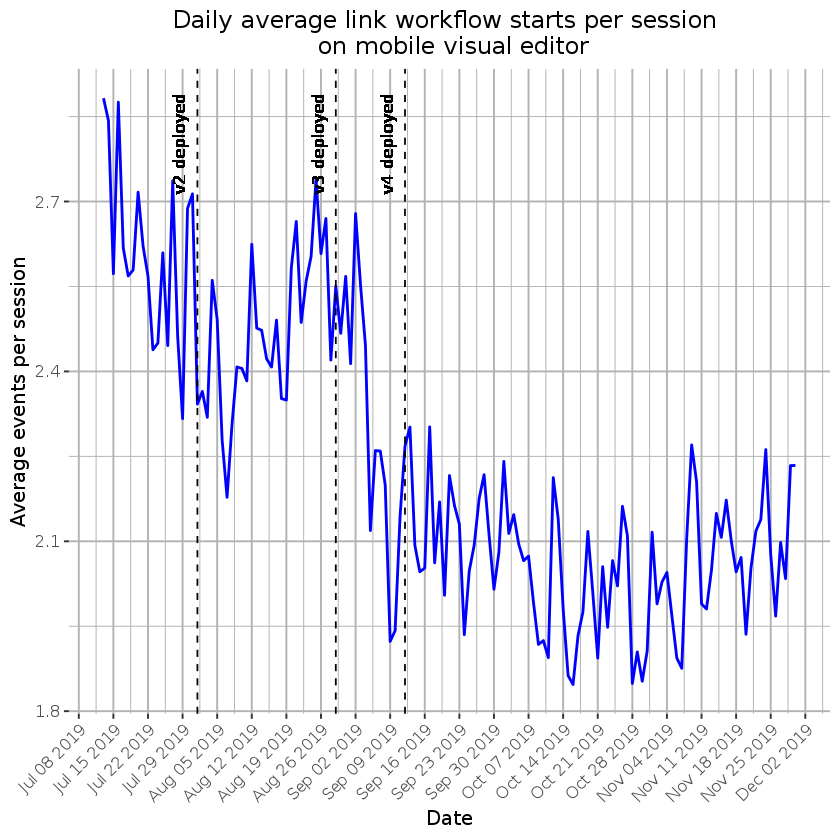

In [1040]:
# Plot timeseries of average link_workflow_starts

p <- ggplot(link_workflow_starts_daily, aes(x= date, y = avg_events)) +    
  geom_line(size =0.8, color = 'blue') +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=2.8, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=2.8, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=2.8, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("Average events per session", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Daily average link workflow starts per session \n on mobile visual editor") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')
 
p
ggsave("Figures/average_link_workflow_starts.png", p, width = 18, height = 9, units = "in", dpi = 150)

### Month over Month Changes in the average link workflow starts per session

In [1030]:
link_workflow_starts_monthly_avg <- link_workflow_starts %>%
    mutate(date = floor_date(date, "month")) %>%
    filter(date != '2019-07-01',
          date != '2019-08-01')  %>% #remove months due to incomplete data
    group_by(date) %>%
    summarise(total_events = sum(events),
             avg_events = mean(events)) %>%
    arrange(date) %>%
    mutate(mom_percent = (avg_events/lag(avg_events,1) -1) *100) %>%
    arrange(desc(date))

link_workflow_starts_monthly_avg

date,total_events,avg_events,mom_percent
<date>,<int>,<dbl>,<dbl>
2019-11-01,159118,2.078860,3.147164
2019-10-01,155166,2.015431,-6.902632
2019-09-01,136854,2.164863,NA


Between v3 and v4 deployments (around September 4, 2019), there was a sharp decrease in the daily average number of link workflow starts per session from about 2.4 to 2.1. Further investigation is needed to determine if this may be caused by another change deployed around this time or is reflective of user behavior. 

After the version 4 deployment, the average rate of link workflow starts has been faily stable and ranged between 1.8 and 2.3 starts per session. There was a 3.1% increase from October to November 2019. 

In [1033]:
#Find the average link workflow starts per session by window-open action type

link_workflow_starts_daily_byaction <- link_workflow_starts %>%
    filter(action %in% c('window-open-from-context', 'window-open-from-tool')) %>%  #Filter to the two primary window actions for links
    group_by(date, action) %>%
    summarise(total_events = sum(events),
             avg_events = mean(events))

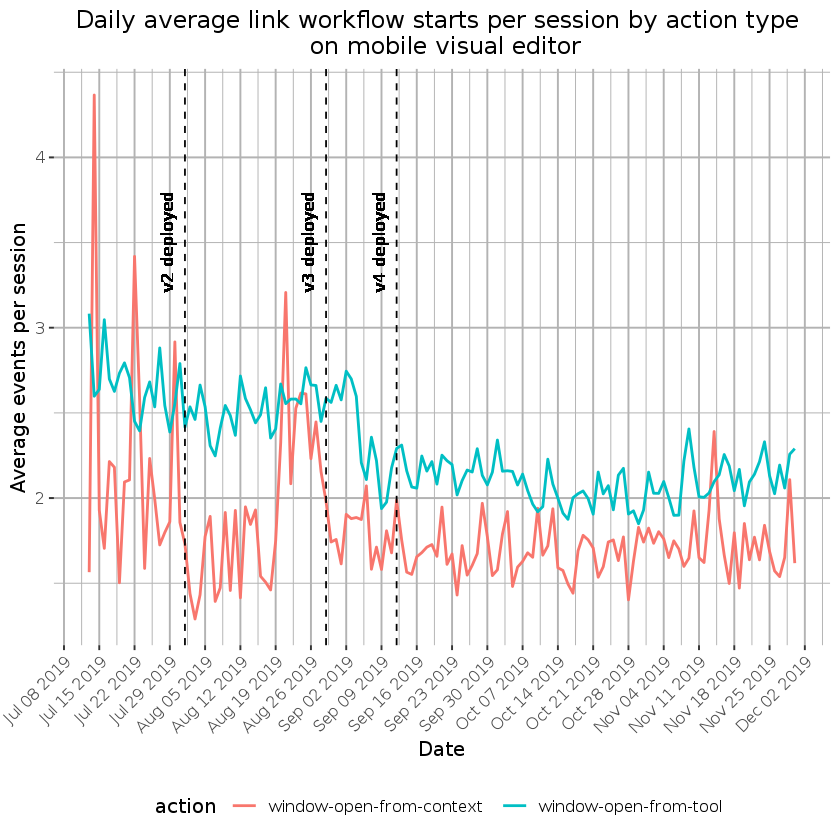

In [1041]:
# Plot timeseries of average link_workflow_starts broken down by action type

p <- ggplot(link_workflow_starts_daily_byaction, aes(x= date, y = avg_events, color = action)) +    
  geom_line(size =0.8) +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=3.5, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=3.5, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=3.5, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("Average events per session", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Daily average link workflow starts per session by action type \n on mobile visual editor") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')
 
p

ggsave("Figures/average_link_workflow_starts_byaction.png", p, width = 18, height = 9, units = "in", dpi = 150)

A breakdown of the average link workflow starts by action type shows a decrease in the window-open-from-tool action between v3 and v4, which occurs when a user clicks the link button in the toolbar to add a new link. This appears to be the primary driver of the decrease observed in the overall rate during this time. 

Following v4 deployment, the average number of link workflow starts per session has remained fairly stable for both action types.


## Daily total link workflow start rates

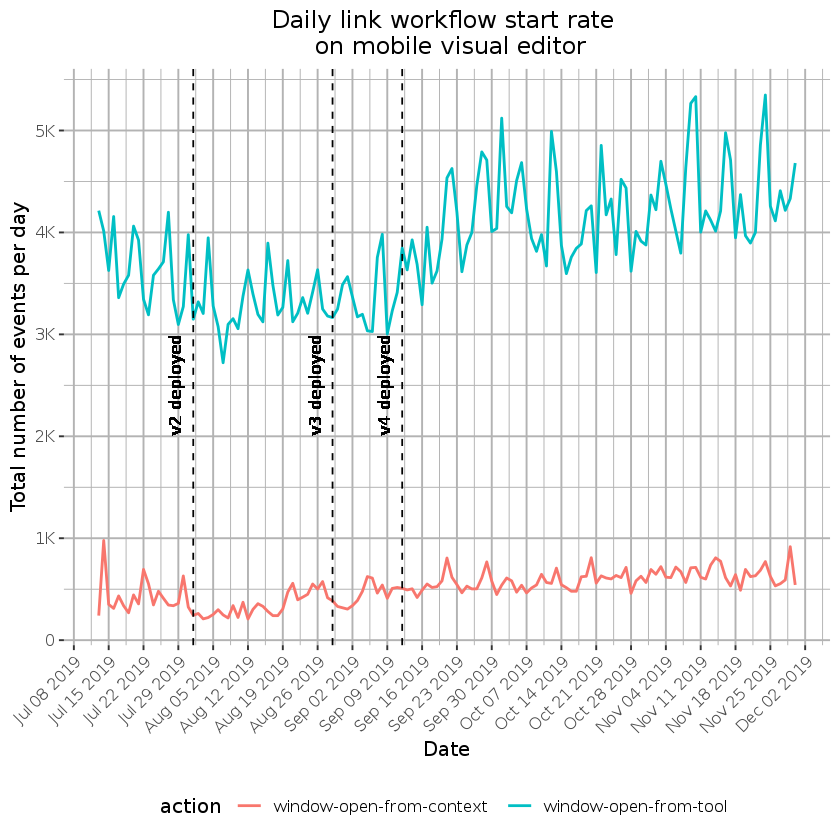

In [1042]:
# Daily total link workflow start rate

p <- ggplot(link_workflow_starts_daily_byaction, aes(x= date, y = total_events, color = action)) +    
  geom_line( size =0.8) +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=2.5E3, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=2.5E3, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=2.5E3, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("Total number of events per day", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Daily link workflow start rate \n on mobile visual editor") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')
 
p

ggsave("Figures/total_link_workflow_starts_byaction.png", p, width = 18, height = 9, units = "in", dpi = 150)

### Month over Month Changes in the total daily link workflow starts

In [1031]:
link_workflow_starts_monthly_total <- link_workflow_starts %>%
    mutate(date = floor_date(date, "month")) %>%
    filter(date != '2019-07-01',
          date != '2019-08-01')  %>% #remove months due to incomplete data
    group_by(date) %>%
    summarise(total_events = sum(events),
             avg_events = mean(events)) %>%
    arrange(date) %>%
    mutate(mom_percent = (total_events/lag(total_events,1) -1) *100) %>%
    arrange(desc(date))

link_workflow_starts_monthly_total

date,total_events,avg_events,mom_percent
<date>,<int>,<dbl>,<dbl>
2019-11-01,159118,2.078860,2.54695
2019-10-01,155166,2.015431,13.38068
2019-09-01,136854,2.164863,NA


There are more additions of new links compared to modifying current ones.

The overall number of link workflow starts per day increase following each deployment. From v2 to v3 of the edit cards, there was a 13% increase in the overall number of link workflow starts per day. Following v4 deployment, the total number of workflow starts has leveled slightly with a 2.5% increase from October to November 2019.

These increases are likely due to an increase in the number of contributors or sessions using edit cards since the number of starts per session did not increase. 

### Percent of sessions shown edit card with engagement

We are also interested in understanding the percent of sessions where contributors who are shown the edit card (revised) or context item (existing) end up engaging with it. This will help determine if the new design made people more likely to start editing in the first place.

We defined this as the percent sessions shown an edit card (recorded as action 'context-show') that open the window to begin editing (recorded as 'window-open-from-context')

In [649]:
query <-
"
--find mobile VE edit sessions that were not included in the AB test 
with non_test_sessions as (
    SELECT DISTINCT event.editing_session_id as session_id
    FROM
        event_sanitized.editattemptstep
    WHERE
        event.bucket is NULL and
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
        year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) 
        )
SELECT
    to_date(dt) as date,
    event.editingsessionid as session_id,
    sum(cast(event.action = 'window-open-from-context' as int)) >= 1 as window_open
FROM event_sanitized.visualeditorfeatureuse as vefu
INNER JOIN
    non_test_sessions 
    ON event.editingsessionid = non_test_sessions.session_id 
WHERE
   -- full data available as of July 13
       year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) and
    event.feature IN ('link', 'link/internal') and
    -- the first action in link workflow starts is context-show
    event.action IN ('context-show', 'window-open-from-context')
GROUP BY
    to_date(dt),
    event.editingsessionid;
"


In [650]:
link_context_shown_engagement <-  wmf::query_hive(query)

In [651]:
link_context_shown_engagement$date <- as.Date(link_context_shown_engagement$date, format = "%Y-%m-%d")

In [1034]:
link_context_shown_engagement_rate <- link_context_shown_engagement %>%
    group_by(date) %>%
    summarise(session_count = n(),
             window_open = sum(window_open == 'true')) %>%
    mutate(window_open_rate = window_open/session_count)
              

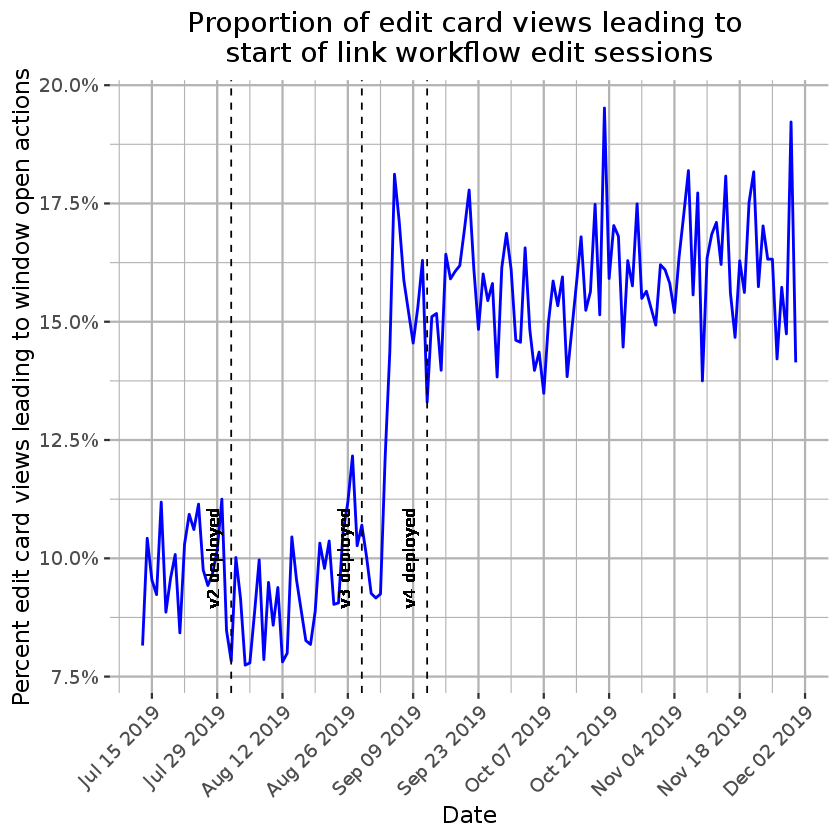

In [999]:
p <- link_context_shown_engagement_rate %>%
  ggplot(aes(x= date, y = window_open_rate)) +    
  geom_line(size = 0.8, color = 'blue') +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=.10, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=.10, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=.10, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("Percent edit card views leading to window open actions", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "2 weeks") +
  labs(title = "Proportion of edit card views leading to \n start of link workflow edit sessions ") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    scale_color_brewer(palette = 'Dark2') +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p


ggsave("Figures/link_context_shown_engagement_rate.png", p, width = 18, height = 9, units = "in", dpi = 150)

In [760]:
link_context_shown_engagement_monthly <- link_context_shown_engagement_rate %>%
    mutate(date = floor_date(date, "month")) %>%
    filter(date != '2019-07-01',
          date != '2019-08-01')  %>% #remove months due to incomplete data
    group_by(date) %>%
    summarise(total_sessions = sum(session_count),
             total_events = sum(window_open),
             window_open_rate = total_events/total_sessions) %>%
    arrange(date) %>%
    mutate(mom_percent = (window_open_rate/lag(window_open_rate,1) -1) *100) %>%
    arrange(desc(date))

link_context_shown_engagement_monthly

date,total_sessions,total_events,window_open_rate,mom_percent
<date>,<int>,<int>,<dbl>,<dbl>
2019-11-01,69453,11276,0.1623544,4.002013
2019-10-01,68389,10676,0.1561070,2.642181
2019-09-01,59827,9099,0.1520885,NA


There was a sudden increase in the percent of editing sessions that started a editing a link once shown the link edit card around September 5, 2019 between v3 and v4. This is correlated to the decrease the average starts per session noted earlier. 

Following v4 deployment on September 12th, there has been a steady increase in the percent of sessions that engage in the editing workflow once shown an edit card. From October to November 2019, there was a 4% increase. About 13%-18% of sessions who view a link context card start an edit.

## Average number of citation workflow starts per session

### Methodology

Similarily to link workflow starts, we measured the start of a citation workflow session with the 'window-open' action as this indicates an intent to edit in most cases. This occurs when a window was opened by clicking the edit button in a context item. We also reviewed the percent of sessions shown the edit card that started the citation editing workflow to determine if the the new design made people more likely in start editing in the first place.

Events are recorded as follows:

Action: User clicks on the citation icon in the toolbar.
<br />
Event: citoid: window-open-from-tool

Action: User clicks an an existing citation
<br />
Event: cite-book (or cite-web, cite-news): context-show then "mwcite": "window-open-from-context"

Action: User clicks on an existing reference
<br />
Event: reference: context-show then reference: window-open-from-context

Note: There were no recorded citoid events or mwcite events (which occurs when a user adds or edits a specific citation template on wikis without Citoid) until the v2 deployment. 

In [745]:
#measure start from "window-open" events.
query <-
"
--find sessions that were not included in the AB test
with non_test_sessions as (
    SELECT DISTINCT event.editing_session_id as session_id
    FROM
        event_sanitized.editattemptstep
    WHERE
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
        event.bucket is NULL and
        year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11))
        )
SELECT
    to_date(dt) as date,
    event.feature as feature,
    event.editingsessionid as session_id,
    Count (*) as events
FROM event_sanitized.visualeditorfeatureuse as vefu
INNER JOIN
    non_test_sessions 
    ON event.editingsessionid = non_test_sessions.session_id 
WHERE
    -- started recorded full data on July 13th
     year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) and
    -- event feature in citoid, reference or mwcite
    event.feature IN ('citoid', 'reference', 'mwcite') and
    -- the first action in a citation workflow is window-open following context-show
    event.action LIKE 'window-open%'
GROUP BY
    to_date(dt),
    event.editingsessionid,
    event.feature
"

In [746]:
citation_workflow_starts <- wmf::query_hive(query)

In [747]:
citation_workflow_starts$date <- as.Date(citation_workflow_starts$date, format = "%Y-%m-%d")

In [961]:
#Find the average link_workflow_starts_per_session

citation_workflow_starts_daily <- citation_workflow_starts %>%
    filter(date >= '2019-08-01') %>% #Did not have full data on all citation workflows until v2 deployment
    group_by(date, feature) %>%
    summarise(total_events = sum(events),
             avg_events = mean(events))

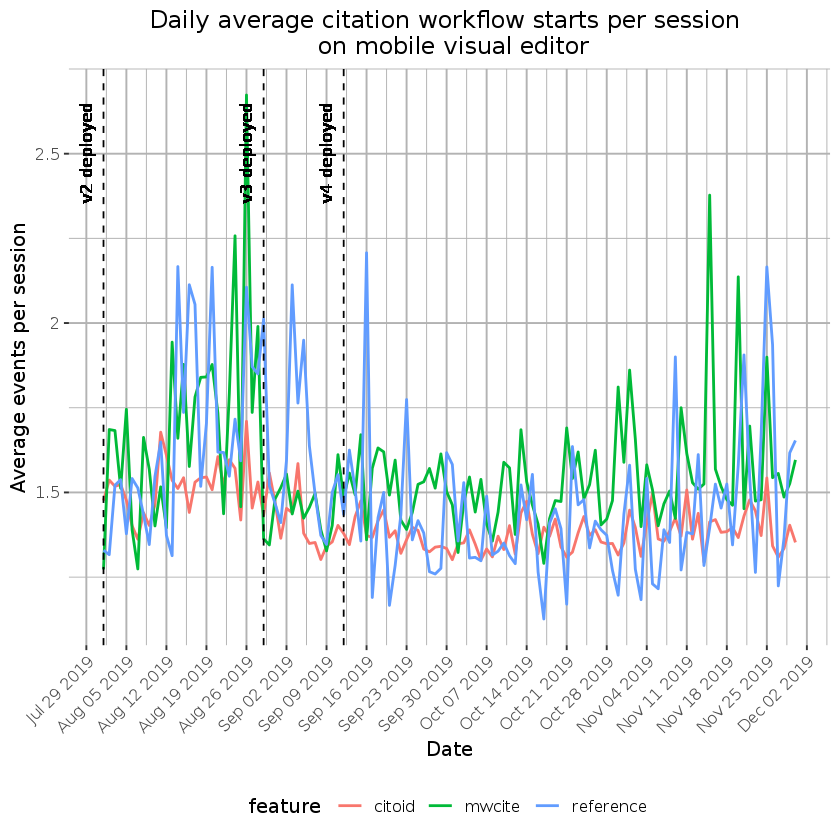

In [1043]:
# Plot timeseries of average citaton_workflow_starts

p <- ggplot(citation_workflow_starts_daily, aes(x= date, y = avg_events, color = feature)) +    
  geom_line(size =0.8) +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=2.5, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=2.5, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=2.5, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("Average events per session", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Daily average citation workflow starts per session \n on mobile visual editor") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')
 
p

ggsave("Figures/average_citation_workflow_starts.png", p, width = 18, height = 9, units = "in", dpi = 150)

### Month over Month Changes in the average citation workflow starts per session

In [963]:
citation_workflow_starts_monthly_avg <- citation_workflow_starts %>%
    mutate(date = floor_date(date, "month")) %>%
    filter(date != '2019-07-01',
          date != '2019-08-01')  %>% #remove months due to incomplete data
    group_by(date) %>%
    summarise(total_events = sum(events),
             avg_events = mean(events)) %>%
    arrange(date) %>%
    mutate(mom_percent = (avg_events/lag(avg_events,1) -1) *100) %>%
    arrange(desc(date))

citation_workflow_starts_monthly_avg

date,total_events,avg_events,mom_percent
<date>,<int>,<dbl>,<dbl>
2019-11-01,70039,1.437140,4.009153
2019-10-01,66875,1.381743,-1.637521
2019-09-01,51911,1.404746,NA


There was a increase in the average citation workflow starts between v2 and v3 edit cards especially for edits using the citation template (recorded as the mwcite feature), which was followed by a decrease in September. Following the v4 deployment, the rate has been fairly stable with about 1 and 2.5 workflow starts per session. From October to November 2019, there was a 4.0% increase in the average number of citation workflow starts per session. 

## Daily total citation workflow starts

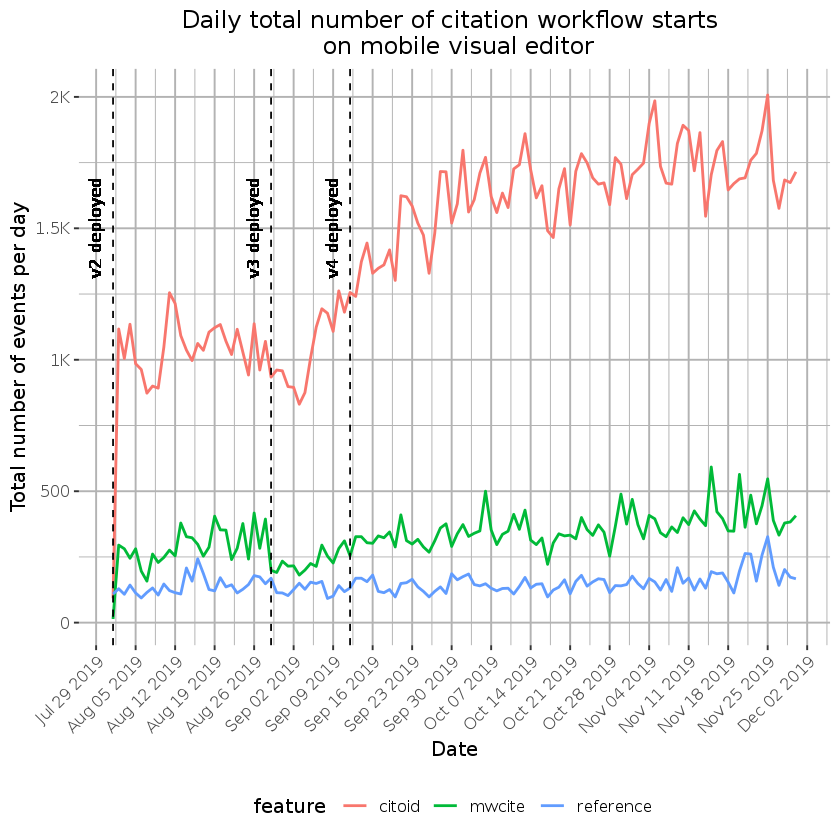

In [1044]:
# Daily rate of citation workflow starts


p <- ggplot(citation_workflow_starts_daily, aes(x= date, y = total_events, color = feature)) +    
  geom_line(size =0.8) +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=1.5E3, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=1.5E3, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=1.5E3, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("Total number of events per day", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Daily total number of citation workflow starts \n on mobile visual editor") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')
 
p
ggsave("Figures/total_citation_workflow_starts.png", p, width = 18, height = 9, units = "in", dpi = 150)

### Month over Month Changes in the daily total citation workflow starts

In [964]:
citation_workflow_starts_monthly_total <- citation_workflow_starts %>%
    mutate(date = floor_date(date, "month")) %>%
    filter(date != '2019-07-01',
          date != '2019-08-01')  %>% #remove months due to incomplete data
    group_by(date) %>%
    summarise(total_events = sum(events),
             avg_events = mean(events)) %>%
    arrange(date) %>%
    mutate(mom_percent = (total_events/lag(total_events,1) -1) *100) %>%
    arrange(desc(date))

citation_workflow_starts_monthly_total

date,total_events,avg_events,mom_percent
<date>,<int>,<dbl>,<dbl>
2019-11-01,70039,1.437140,4.731215
2019-10-01,66875,1.381743,28.826260
2019-09-01,51911,1.404746,NA


Similarily to the trends we observed for link workflow starts, the number of citation workflows have been increasing following the deployment of v2 to edit cards. From September to October 2019 (following v3 and v4 deployments, there was a 28.8% increase in the daily total number of citation workflow starts. This increase appears to be largely driven by citoid-generated references; however, there were also increases by citation-template (mwcite) and reference generated references.

## Percent of sessions shown edit card with engagement

We are also interested in understanding the percent of sessions where contributors who are shown the edit card (revised) or context item (existing) end up engaging with it. This will help determine if the new design made people more likely to start editing in the first place.

We defined this as the percent sessions shown an edit card (recorded as action 'context-show') that open the window to begin editing (recorded as 'window-open-from-context')

In [664]:
#Note: Context shown items don't appear to be recorded for citoid events where a user generates a new reference.

query <-
"
--find mobile VE edit sessions that were not included in the AB test 
with non_test_sessions as (
    SELECT DISTINCT event.editing_session_id as session_id
    FROM
        event_sanitized.editattemptstep
    WHERE
        event.bucket is NULL and
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
        year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) 
        )
SELECT
    to_date(dt) as date,
    event.editingsessionid as session_id,
    sum(cast(event.action = 'window-open-from-context' as int)) >= 1 as window_open
FROM event_sanitized.visualeditorfeatureuse as vefu
INNER JOIN
    non_test_sessions 
    ON event.editingsessionid = non_test_sessions.session_id 
WHERE
   -- full data available as of July 13
       year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) and
    (event.feature LIKE 'cite%' or
    event.feature IN ('reference', 'mwcite')) and
    -- the first action in link workflow starts is context-show
    event.action IN ('context-show', 'window-open-from-context')
GROUP BY
    to_date(dt),
    event.editingsessionid;
"


In [665]:
citation_context_shown_engagement <-  wmf::query_hive(query)

In [666]:
citation_context_shown_engagement$date <- as.Date(citation_context_shown_engagement$date, format = "%Y-%m-%d")

In [1035]:
citation_context_shown_engagement_rate <- citation_context_shown_engagement %>%
    group_by(date) %>%
    filter(date >= '2019-08-01') %>% #Did not have full data on all citation workflows until v2 deployment
    summarise(session_count = n(),
             window_open = sum(window_open == 'true')) %>%
    mutate(window_open_rate = window_open/session_count)

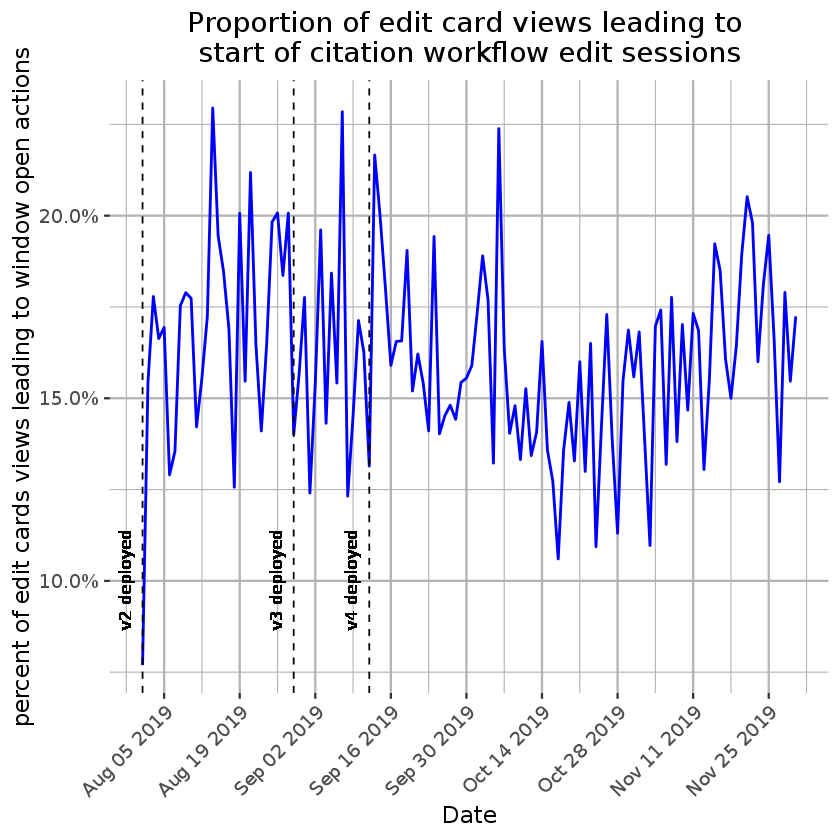

In [1045]:
p <- citation_context_shown_engagement_rate %>%
  ggplot(aes(x= date, y = window_open_rate)) +    
  geom_line(size = 0.8, color = 'blue') +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=.10, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=.10, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=.10, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("percent of edit cards views leading to window open actions", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "2 weeks") +
  labs(title = "Proportion of edit card views leading to \n start of citation workflow edit sessions ") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    scale_color_brewer(palette = 'Dark2') +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p

ggsave("Figures/citation_context_shown_engagement_rate.png", p, width = 18, height = 9, units = "in", dpi = 150)

In [967]:
citation_context_shown_engagement_monthly <- citation_context_shown_engagement_rate %>%
    mutate(date = floor_date(date, "month")) %>%
    filter(date != '2019-07-01',
          date != '2019-08-01')  %>% #remove months due to incomplete data
    group_by(date) %>%
    summarise(total_sessions = sum(session_count),
             total_events = sum(window_open),
             window_open_rate = total_events/total_sessions) %>%
    arrange(date) %>%
    mutate(mom_percent = (window_open_rate/lag(window_open_rate,1) -1) *100) %>%
    arrange(desc(date))

citation_context_shown_engagement_monthly

date,total_sessions,total_events,window_open_rate,mom_percent
<date>,<int>,<int>,<dbl>,<dbl>
2019-11-01,21019,3469,0.1650412,9.894178
2019-10-01,20342,3055,0.1501819,-7.574144
2019-09-01,17115,2781,0.1624890,NA


About 12 to 22% of all sessions show an edit card end up starting the citation workflow process.

There were no signficant changes in the engagement rate immediately following the v3 or v4 deployments. There was a -7.6% month over month decrease in October; however, the rate has been increasing since October. There was a 9.9% increase in November. Note: These fluctuatations may partly be due to seaonality effects.

# Are contributors more likely to finish adding and modifying links and citations?

## Link Workflow Completion Rate

### Methodology

We defined link completion rate as the number of sessions with link workflow starts (measured by window-open actions) that reach dialog-done, dialog-insert, or dialog-remove.

**Events are recorded as follows:**

*Same for both internal and external links*
<br />
Action:User makes change and the selects check box to save
<br />
Event: Link: dialog-done 




In [871]:
query <-
"
--find sessions that were not included in the VE as default AB test
with non_test_sessions as (
    SELECT DISTINCT event.editing_session_id as session_id
    FROM
        event_sanitized.editattemptstep
    WHERE
        event.bucket is NULL and
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
        year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) 
        )
SELECT
    to_date(min(dt)) as date,
    event.editingsessionid as session_id,
    sum(cast(event.action = 'dialog-done' as int)) >= 1 as completed
FROM event_sanitized.visualeditorfeatureuse as vefu
INNER JOIN
    non_test_sessions 
    ON event.editingsessionid = non_test_sessions.session_id 
WHERE

    year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) and
    event.feature = 'link' and
    (event.action LIKE 'window-open%' OR 
    event.action ='dialog-done')
GROUP BY
     to_date(dt),
    event.editingsessionid"

In [872]:
link_workflow_completes <- wmf::query_hive(query)

In [1036]:
link_workflow_completion_rate <- link_workflow_completes  %>%
    group_by(date) %>%
    summarise(session_count = n(),
             completed = sum(completed == 'true')) %>%
    mutate(completion_rate = completed/session_count)
              

In [1048]:
link_workflow_completion_rate$date <- as.Date(link_workflow_completion_rate$date, format = "%Y-%m-%d")

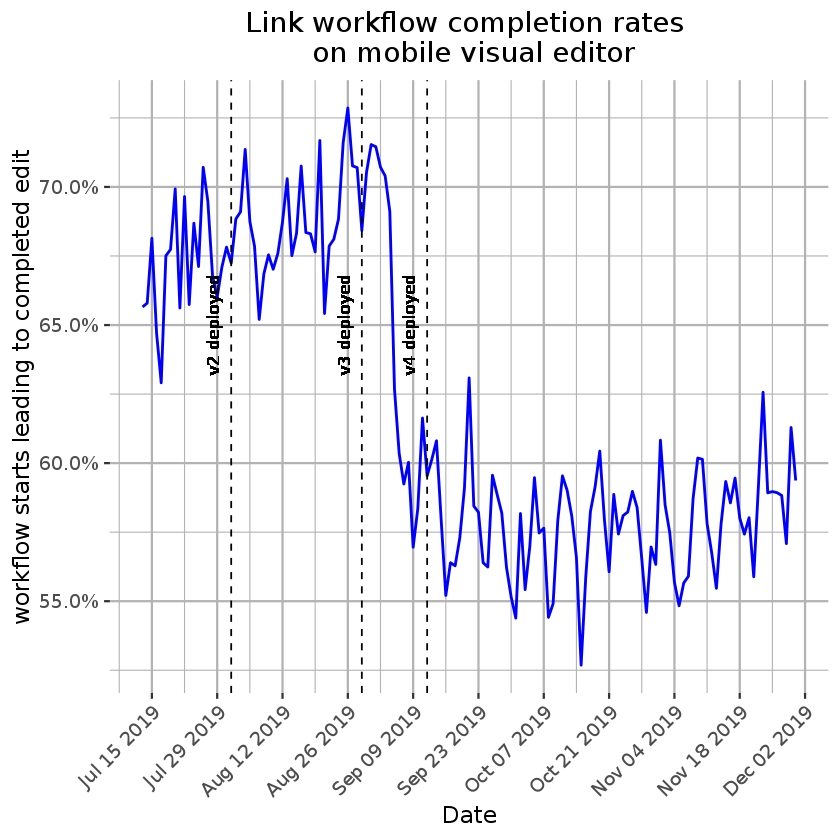

In [1049]:
p <- link_workflow_completion_rate %>%
  ggplot(aes(x= date, y = completion_rate)) +    
  geom_line(size = 0.8, color = 'blue') +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=.65, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=.65, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=.65, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("workflow starts leading to completed edit", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "2 weeks") +
  labs(title = "Link workflow completion rates \n on mobile visual editor") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    scale_color_brewer(palette = 'Dark2') +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p

ggsave("Figures/link_workflow_completion_rate.png", p, width = 18, height = 9, units = "in", dpi = 150)

### Month over month changes in link workflow completion rate

In [836]:
link_workflow_completion_rate_monthly <- link_workflow_completion_rate %>%
    mutate(date = floor_date(date, "month")) %>%
    filter(date != '2019-07-01',
          date != '2019-08-01')  %>% #remove months due to incomplete data
    group_by(date) %>%
    summarise(total_sessions = sum(session_count),
             total_completes = sum(completed),
             completion_rate = total_completes/total_sessions) %>%
    arrange(date) %>%
    mutate(mom_percent = (completion_rate/lag(completion_rate,1) -1) *100) %>%
    arrange(desc(date))

link_workflow_completion_rate_monthly

date,total_sessions,total_completes,completion_rate,mom_percent
<date>,<int>,<int>,<dbl>,<dbl>
2019-11-01,70396,41022,0.5827320,1.698699
2019-10-01,71070,40723,0.5729985,-4.049943
2019-09-01,58240,34780,0.5971841,NA


Link completion rates range from 53% to 63%. 

There was a sudden decrease in link workflow completion rates from August to September 2019 following the v3 deployment. Based on trends noted earlier, this may be related to an increase in new users or deployment change around that timeframe.

Following v4 deployment, the link completion rate has remaining fairly stable with a slight 1.7% increase from October to November 2019.

## Citation Workflow Completion Rates

### Methodology

We defined citation completion rate as the number of sessions with citation workflow starts (recorded as window-open actions) that reach dialog-done, dialog-insert, or dialog-remove events. 

Events are recorded as follows:

*Citoid generated events*
<br />
Action: User makes changes and selects the check box to complete
<br />
Event: Cite: Dialog-done

*Citation-template generated events*
<br />
Action: User makes change and selects the check box to complete
<br />
Event: Cite: Dialog-Done

*Reference-dialog generated events*
Acton: User makes changes and selects the check box to complete
<br />
Event: reference: dialog-done

In [979]:
query <-
"
--find mobile VE sessions that were not included in the VE as default AB test
with non_test_sessions as (
    SELECT DISTINCT event.editing_session_id as session_id
    FROM
        event_sanitized.editattemptstep
    WHERE
        event.bucket is NULL and
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
        year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) 
        )
SELECT
    to_date(min(dt)) as date,
    event.editingsessionid as session_id,
    sum(cast(event.action IN ('dialog-done','dialog-insert', 'dialog-remove') as int)) >= 1 as completed
FROM event_sanitized.visualeditorfeatureuse as vefu
INNER JOIN
    non_test_sessions 
    ON event.editingsessionid = non_test_sessions.session_id 
WHERE

    year = 2019 and ((month = 07 and day >= 13) OR (month >=08 AND month <= 11)) and
--all dialog-done events appear to be recored under either reference and cite features
    event.feature IN ('reference', 'cite', 'mwcite', 'citoid') and
    (event.action LIKE 'window-open%' OR 
    event.action IN ('dialog-done', 'dialog-insert', 'dialog-remove'))
GROUP BY
    event.editingsessionid"

In [980]:
citation_workflow_completes <- wmf::query_hive(query)

In [1037]:
citation_workflow_completes$date <- as.Date(citation_workflow_completes$date, format = "%Y-%m-%d")

In [1038]:
citation_workflow_completion_rate <- citation_workflow_completes  %>%
    group_by(date) %>%
    summarise(session_count = n(),
             completed = sum(completed == 'true')) %>%
    mutate(completion_rate = completed/session_count)
            

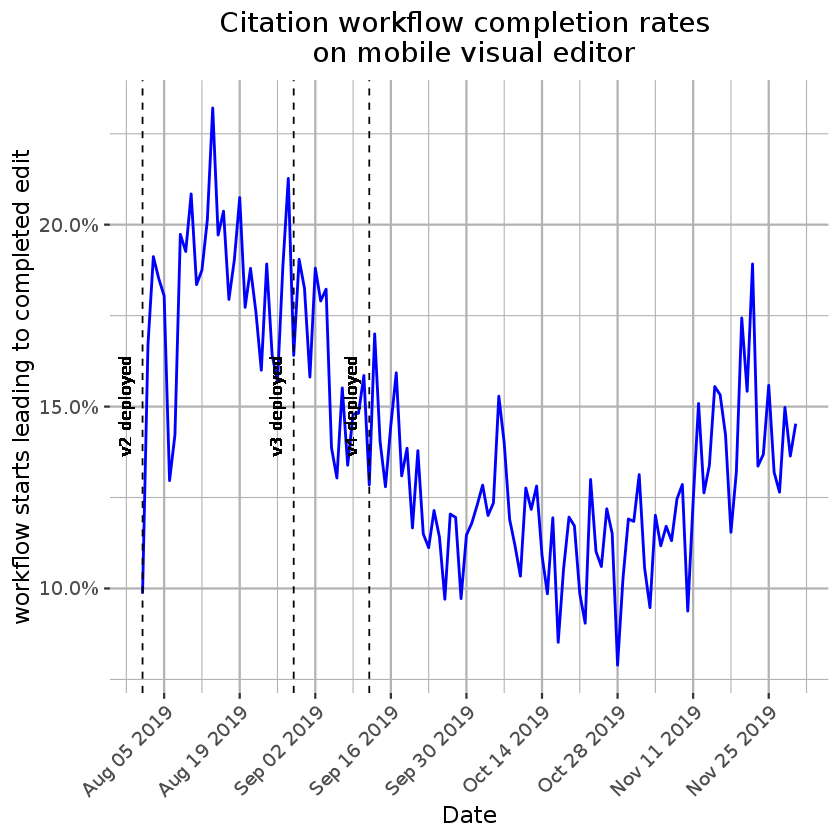

In [1051]:
p <- citation_workflow_completion_rate %>%
    filter(date >= '2019-08-01') %>% #when we have full citation data available
  ggplot(aes(x= date, y = completion_rate)) +    
  geom_line(size = 0.8, color = 'blue') +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=.15, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=.15, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=.15, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("workflow starts leading to completed edit", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "2 weeks") +
  labs(title = "Citation workflow completion rates \n on mobile visual editor") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    scale_color_brewer(palette = 'Dark2') +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p
ggsave("Figures/citation_workflow_completion_rate.png", p, width = 18, height = 9, units = "in", dpi = 150)

### Month over Month changes in Citation Workflow Completion Rate

In [985]:
citation_workflow_completion_rate_monthly <- citation_workflow_completion_rate %>%
    mutate(date = floor_date(date, "month")) %>%
    filter(date != '2019-07-01',
          date != '2019-08-01')  %>% #remove months due to incomplete data
    group_by(date) %>%
    summarise(total_sessions = sum(session_count),
             total_completes = sum(completed),
             completion_rate = total_completes/total_sessions) %>%
    arrange(date) %>%
    mutate(mom_percent = (completion_rate/lag(completion_rate,1) -1) *100) %>%
    arrange(desc(date))

citation_workflow_completion_rate_monthly 

date,total_sessions,total_completes,completion_rate,mom_percent
<date>,<int>,<int>,<dbl>,<dbl>
2019-11-01,40192,5364,0.1334594,15.60819
2019-10-01,40159,4636,0.1154411,-13.86599
2019-09-01,30457,4082,0.1340250,NA


There has been a decrease in the citation workflow completion rate following each deployment from August to October 2019. This may be due to an increase in new users using the edit cards as we saw a steady increase in the total number of citation workflow starts. In November, we saw the complete rate start to go back up and there was a 15.7% increase from October to November 2019.

The citation worflow completion rates are lower compared to the link workflow completion rate. Citation workflow completion rates ranged between 12-23% while link workflow completion rate ranged between 53-73%. 

# Are contributors more likely to publish their edits?

## Edit Completion Rate

### Methodology

Data comes from the [EditAttemptStep](https://meta.wikimedia.org/wiki/Schema:EditAttemptStep) schema. For the purposes of this analysis, we defined edit completion rate as the proportion of ready events that are saved. 

We reviewed the edit completion rate for all Wikipedias on mobile Visual Editor and compared pre and post deployment rates. We also reviewed edit completion rates for different contributor experience levels.

In [800]:
query <- 
"with attempts as (
    select
        to_date(min(dt)) as date,
        sum(cast(event.action = 'saveSuccess' as int)) >= 1 as completed,
        min(event.user_id) = 0 as unregistered,
        min(event.user_editcount) between 1 and 4 as one_to_four_edits,
        min(event.user_editcount)  >= 5 AND min(event.user_editcount) < 100 as five_99_edits,
        min(event.user_editcount)  >= 100 AND min(event.user_editcount) < 1000 as onehunderd_999_edits,
        min(event.user_editcount)  >= 1000 as over_1000
    from event_sanitized.editattemptstep
    inner join canonical_data.wikis 
    on wiki = database_code and
    database_group ==  'wikipedia'
    where
        event.platform = 'phone' and
        event.editor_interface = 'visualeditor' and
        event.action in ('ready', 'saveSuccess') and
-- Remove users in the VE AB Test bucket
        event.bucket is NULL and
        year = 2019 and (month >= 04 and month <= 11)
    group by event.editing_session_id
)
select
    date,
    sum(cast(completed as int)) / count(*) as edit_completion,
    sum(cast(completed and unregistered as int)) / sum(cast(unregistered as int)) as unregistered,
    sum(cast(completed and one_to_four_edits as int)) / sum(cast(one_to_four_edits as int)) as one_to_four_edits,
    sum(cast(completed and five_99_edits as int)) / sum(cast(five_99_edits as int)) as five_99_edits,
    sum(cast(completed and onehunderd_999_edits as int)) / sum(cast(onehunderd_999_edits as int)) as onehunderd_999_edits,
    sum(cast(completed and over_1000 as int)) / sum(cast(over_1000 as int)) as over_1000_edits
from attempts
group by date"


In [801]:
edit_completion_rate <- wmf::query_hive(query)

In [802]:
edit_completion_rate$date <- as.Date(edit_completion_rate$date, format = "%Y-%m-%d")

In [803]:
#Remove missing data due to https://phabricator.wikimedia.org/T221197#5305019

edit_completion_rate <- subset(edit_completion_rate, date < "2019-06-26" | date > "2019-07-03")

In [805]:
# rename columns
names(edit_completion_rate) <- c("date", "overall", "unregistered", "1-4 edits", "5-99 edits", "100-999 edits", "1,000+ edits")


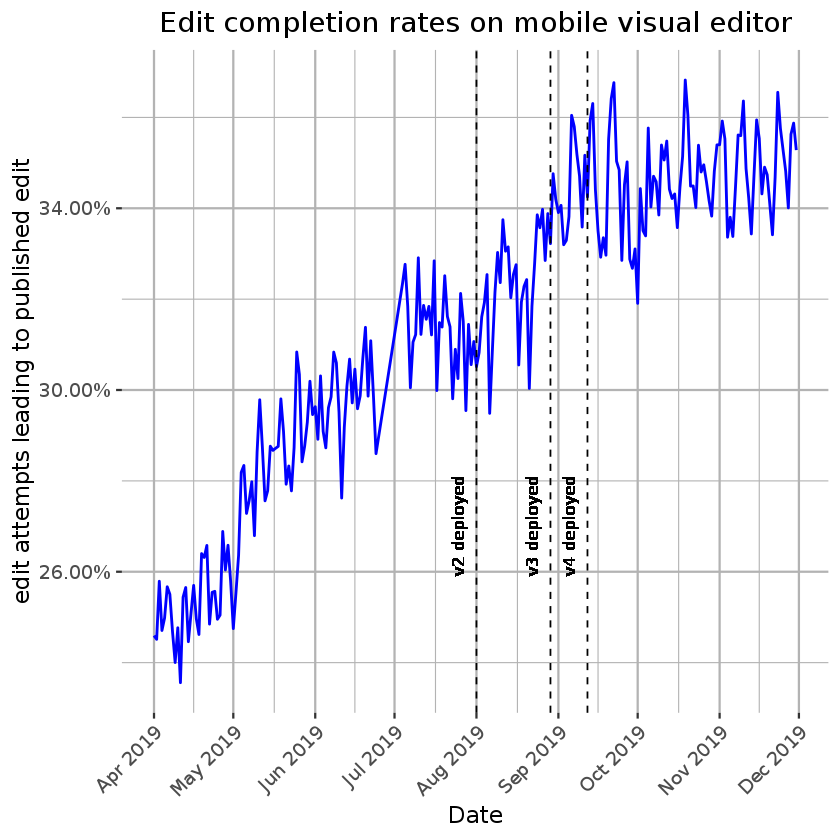

In [1007]:
p <- edit_completion_rate %>%
  gather("editor_experience", "edit_attempts", 2:7)  %>%
  filter(editor_experience == 'overall') %>%
  # mutate(rolling_average = rollmean(as.numeric(edit_attempts), 7, na.pad=TRUE, align="right")) %>%
  ggplot(aes(x= date, y = as.numeric(edit_attempts))) +    
  geom_line(size = 0.8, color = 'blue') +
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=.27, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=.27, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=.27, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("edit attempts leading to published edit", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
  labs(title = "Edit completion rates on mobile visual editor") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    scale_color_brewer(palette = 'Dark2') +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p
ggsave("Figures/edit_completion_rate_overall.png", p, width = 18, height = 9, units = "in", dpi = 150)


### Month over month changes in overall edit completion rates

In [810]:
edit_completion_monthly <- edit_completion_rate %>%
    gather("editor_experience", "edit_attempts", 2:7)  %>%
    filter(editor_experience == 'overall') %>%
    mutate(date = floor_date(date, "month")) %>%
    group_by(date) %>%
    summarise(edit_attempts = mean(as.numeric(edit_attempts))) %>%
    arrange(date) %>%
    mutate(mom_percent = (edit_attempts/lag(edit_attempts,1) -1) *100) %>%
    arrange(desc(date))

edit_completion_monthly 

date,edit_attempts,mom_percent
<date>,<dbl>,<dbl>
2019-11-01,0.3491697,0.9674821
2019-10-01,0.3458239,0.5251332
2019-09-01,0.3440173,6.1410499
2019-08-01,0.3241134,3.3255972
2019-07-01,0.3136816,5.2942483
2019-06-01,0.2979095,5.0442749
2019-05-01,0.2836038,12.0610488
2019-04-01,0.2530797,NA


The edit completion rate on mobile visual editor has been steadily increasing; however, this trend has been occuring  prior to the edit card deployment and may be due to other variables such an increase in the number of new and returning active editors and seasonal changes.

### Edit completion rates by experience levels

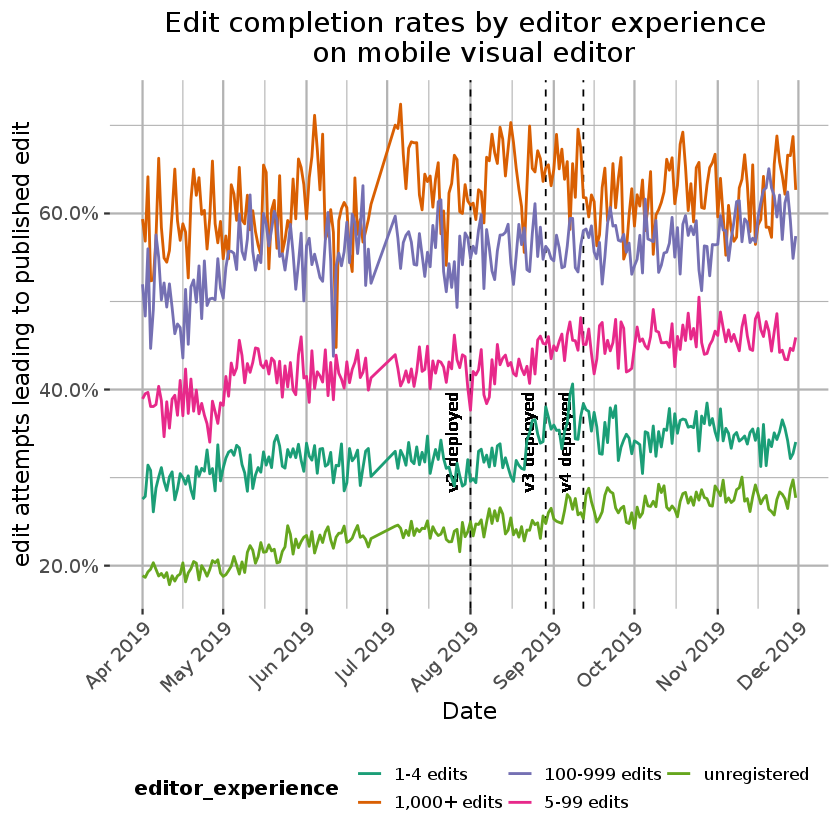

In [1017]:
p <- edit_completion_rate %>%
  gather("editor_experience", "edit_attempts", 2:7)  %>%
  filter(editor_experience != 'overall') %>%
  ggplot(aes(x= date, y = as.numeric(edit_attempts), color = editor_experience)) +  
  geom_vline(xintercept = c(as.Date('2019-08-01'), as.Date('2019-08-29'), as.Date('2019-09-12')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-08-01'), y=.34, label= 'v2 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-08-29'), y=.34, label='v3 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-09-12'), y=.34, label='v4 deployed'), size=3.6, vjust = -1, angle = 90, color = "black") +
  geom_line(size = 0.8) +
  scale_y_continuous("edit attempts leading to published edit", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
  labs(title = "Edit completion rates by editor experience \n on mobile visual editor") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    scale_color_brewer(palette = 'Dark2') +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=10)) + 
        guides(colour = guide_legend(nrow = 2))
p 

ggsave("Figures/edit_completion_rate_byexperience.png", p, width = 18, height = 9, units = "in", dpi = 150)


### Month over month changes in overall edit completion rates by experience level

**Unregistered**

In [1025]:
#unregistered

edit_completion_monthly_unregistered <- edit_completion_rate %>%
    gather("editor_experience", "edit_attempts", 2:7)  %>%
    filter(editor_experience == 'unregistered') %>%
    mutate(date = floor_date(date, "month")) %>%
    group_by(date) %>%
    summarise(edit_attempts = mean(as.numeric(edit_attempts))) %>%
    arrange(date) %>%
    mutate(mom_percent = (edit_attempts/lag(edit_attempts,1) -1) *100) %>%
    arrange(desc(date))

edit_completion_monthly_unregistered

date,edit_attempts,mom_percent
<date>,<dbl>,<dbl>
2019-11-01,0.2782074,2.179111
2019-10-01,0.2722742,2.721889
2019-09-01,0.2650596,7.242253
2019-08-01,0.2471597,3.784395
2019-07-01,0.2381472,2.714851
2019-06-01,0.2318528,8.836948
2019-05-01,0.2130276,10.177789
2019-04-01,0.1933490,NA


**1-4 edits**

In [1026]:
#1-4 edits

edit_completion_monthly_1_4edits <- edit_completion_rate %>%
    gather("editor_experience", "edit_attempts", 2:7)  %>%
    filter(editor_experience == '1-4 edits') %>%
    mutate(date = floor_date(date, "month")) %>%
    group_by(date) %>%
    summarise(edit_attempts = mean(as.numeric(edit_attempts))) %>%
    arrange(date) %>%
    mutate(mom_percent = (edit_attempts/lag(edit_attempts,1) -1) *100) %>%
    arrange(desc(date))

edit_completion_monthly_1_4edits

date,edit_attempts,mom_percent
<date>,<dbl>,<dbl>
2019-11-01,0.3446814,-2.3649472
2019-10-01,0.3530303,-0.9759465
2019-09-01,0.3565097,8.5606026
2019-08-01,0.3283969,3.2742327
2019-07-01,0.3179854,-0.1175740
2019-06-01,0.3183597,-0.6044624
2019-05-01,0.3202957,7.4073341
2019-04-01,0.2982066,NA


**5-99 edits**

In [1028]:
#5-99 edits

edit_completion_monthly_5_99edits <- edit_completion_rate %>%
    gather("editor_experience", "edit_attempts", 2:7)  %>%
    filter(editor_experience == '5-99 edits') %>%
    mutate(date = floor_date(date, "month")) %>%
    group_by(date) %>%
    summarise(edit_attempts = mean(as.numeric(edit_attempts))) %>%
    arrange(date) %>%
    mutate(mom_percent = (edit_attempts/lag(edit_attempts,1) -1) *100) %>%
    arrange(desc(date))

edit_completion_monthly_5_99edits 

date,edit_attempts,mom_percent
<date>,<dbl>,<dbl>
2019-11-01,0.4600933,0.2448963
2019-10-01,0.4589693,1.6589214
2019-09-01,0.4514796,5.8213880
2019-08-01,0.4266430,0.3854017
2019-07-01,0.4250050,1.7928663
2019-06-01,0.4175195,-1.2370718
2019-05-01,0.4227492,10.6661263
2019-04-01,0.3820041,NA


In [1022]:
#100-999 edits

edit_completion_monthly_100_999edits <- edit_completion_rate %>%
    gather("editor_experience", "edit_attempts", 2:7)  %>%
    filter(editor_experience == '100-999 edits') %>%
    mutate(date = floor_date(date, "month")) %>%
    group_by(date) %>%
    summarise(edit_attempts = mean(as.numeric(edit_attempts))) %>%
    arrange(date) %>%
    mutate(mom_percent = (edit_attempts/lag(edit_attempts,1) -1) *100) %>%
    arrange(desc(date))


**Over 1000 edits**

In [1029]:
#over 1000 edits

edit_completion_monthly_over1000_edits <- edit_completion_rate %>%
    gather("editor_experience", "edit_attempts", 2:7)  %>%
    filter(editor_experience == '1,000+ edits') %>%
    mutate(date = floor_date(date, "month")) %>%
    group_by(date) %>%
    summarise(edit_attempts = mean(as.numeric(edit_attempts))) %>%
    arrange(date) %>%
    mutate(mom_percent = (edit_attempts/lag(edit_attempts,1) -1) *100) %>%
    arrange(desc(date))

edit_completion_monthly_over1000_edits

date,edit_attempts,mom_percent
<date>,<dbl>,<dbl>
2019-11-01,0.6187432,-1.5430845
2019-10-01,0.6284406,0.4806147
2019-09-01,0.6254346,-3.3260198
2019-08-01,0.6469524,0.9833006
2019-07-01,0.6406528,6.4583388
2019-06-01,0.6017874,0.3334112
2019-05-01,0.5997876,1.5571295
2019-04-01,0.5905913,NA


Following the deployment of edit cards v2 to all wikis, we observed the highest increase in edit completion rates for junior contributors. From August to September 2019, there was an 8.6% increase for contributors with 1-4 edits and 5.8% for contributors with 5 to 99 edits. In contrast, there was minimal change for contributors with over 100 edits.
